## Define models and load ground truths

In [1]:
from copy import deepcopy
from collections import defaultdict, Counter

import sympy
import pandas as pd

# BIOMD0000000955 - https://pmc.ncbi.nlm.nih.gov/articles/PMC7175834/
# BIOMD0000000956 - https://pmc.ncbi.nlm.nih.gov/articles/PMC7382213/
# BIOMD0000000957 - https://pmc.ncbi.nlm.nih.gov/articles/PMC7104073/
# BIOMD0000000958 - https://pmc.ncbi.nlm.nih.gov/articles/PMC7184012/
# BIOMD0000000960 - https://pmc.ncbi.nlm.nih.gov/articles/PMC7394373/


biomodels = [
    "BIOMD0000000955",
    "BIOMD0000000956",
    "BIOMD0000000957",
    "BIOMD0000000958",
    "BIOMD0000000960",
]
external_models = ["model_a_2024_12", "model_b_2024_12", "model_c_2024_12"]
model_ids = biomodels + external_models


# Old TA1 Extraction results
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ2G-ZFSotS2qo94mnTWCDvj9Y49ai-9O61DA7940sPYynEdBXq2cT2-Wl3nNldIb3gkpbPFaTFY2PJ/pub?output=xlsx"
xls = pd.ExcelFile(url)

sheets = {
    sheet_name: pd.read_excel(xls, sheet_name) for sheet_name in xls.sheet_names
}
for sheet in sheets.values():
    sheet["grounding"] = sheet["grounding"].map(eval)
set(sheets)

{'BIOMD0000000955',
 'BIOMD0000000956',
 'BIOMD0000000957',
 'BIOMD0000000958',
 'BIOMD0000000960'}

In [2]:
# Store just compartment identifiers for TA1 evaluation using comparison with just identifiers stored in "dd_ta1"
# Store compartment identifiers and context for the MIRA-LLM grounding evaluation with both identifiers and context stored in "dd_llm"

# Store the biomodel mappings
ground_truth_df = pd.read_csv(
    "../mira/resources/mapped_biomodels_groundings.csv", sep=","
)

dd_llm = defaultdict(dict)
dd_ta1 = defaultdict(set)

for row_index, entry in ground_truth_df.iterrows():
    model_id = entry["model"]
    if model_id not in biomodels:
        continue
    concept_curie = None

    # Store name and identifiers
    concept_dict = {}
    concept_name = entry["name"]
    concept_dict["name"] = concept_name
    concept_dict["context"] = set()
    curie = None
    curie_tuple = None
    if not pd.isna(entry["mapped_identifiers"]):
        curie = entry["mapped_identifiers"].split("/")[0]
        concept_dict["identifier"] = curie
        dd_ta1[model_id].add(curie)
        split_curie = curie.split(":")
        curie_tuple = (split_curie[0], split_curie[1])
    # Store contexts
    if not pd.isna(entry["mapped_context"]):
        contexts = entry["mapped_context"].split("|")

        context = contexts[0]
        context_kv_pair = context.split("=")

        key = context_kv_pair[0]
        value = context_kv_pair[1].split("/")[0]

        concept_dict["context"].add((key, value))

        for context_str in contexts[1:]:
            context_str_kv_pair = context_str.split("=")
            key = context_str_kv_pair[0]
            value = context_str_kv_pair[1].split("/")[0]
            concept_dict["context"].add((key, value))

    key = (curie_tuple, tuple(concept_dict["context"]))
    dd_llm[model_id][key] = concept_dict

In [3]:
# Instantiate the data structure used to define the ground truths for concepts from the generated external models
external_ground_truth_data = [
    {
        "name": "sI",
        "model": "model_a_2024_12",
        "mapped_identifiers": "ido:0000514/susceptible low risk human population",
        "mapped_context": "species=ncbitaxon:9606/human|disease_severity=ncit:C92638/mild",
    },
    {
        "name": "sH",
        "model": "model_a_2024_12",
        "mapped_identifiers": "ido:0000514/susceptible high risk human population",
        "mapped_context": "species=ncbitaxon:9606/human|disease_severity=ncit:C92640/severe",
    },
    {
        "name": "eH",
        "model": "model_a_2024_12",
        "mapped_identifiers": "apollosv:00000154/exposed human population",
        "mapped_context": "species=ncbitaxon:9606/human|quarantined=ncit:C68851/False",
    },
    {
        "name": "p",
        "model": "model_a_2024_12",
        "mapped_identifiers": "ido:0000511/infectious human population",
        "mapped_context": "species=ncbitaxon:9606/human|disease_severity=ncit:C3833/Asymptomatic",
    },
    {
        "name": "i1",
        "model": "model_a_2024_12",
        "mapped_identifiers": "ido:0000511/mildly infectious human population",
        "mapped_context": "species=ncbitaxon:9606/human|disease_severity=ncit:C92638/mild",
    },
    {
        "name": "i2",
        "model": "model_a_2024_12",
        "mapped_identifiers": "ido:0000511/severely infectious human population",
        "mapped_context": "species=ncbitaxon:9606/human|disease_severity=ncit:C92640/severe",
    },
    {
        "name": "h",
        "model": "model_a_2024_12",
        "mapped_identifiers": "ido:0000511/infected population",
        "mapped_context": "hospitalization=ncit:C25179/Hospitalization|species=ncbitaxon:9606/human",
    },
    {
        "name": "rH",
        "model": "model_a_2024_12",
        "mapped_identifiers": "ido:0000592/recovered human population",
        "mapped_context": "species=ncbitaxon:9606/human",
    },
    {
        "name": "sR",
        "model": "model_a_2024_12",
        "mapped_identifiers": "ido:0000514/susceptible rodent population",
        "mapped_context": "species=ncbitaxon:9989/rodent",
    },
    {
        "name": "eR",
        "model": "model_a_2024_12",
        "mapped_identifiers": "apollosv:00000154/exposed rodent population",
        "mapped_context": "species=ncbitaxon:9989/rodent",
    },
    {
        "name": "iR",
        "model": "model_a_2024_12",
        "mapped_identifiers": "ido:0000511/infectious rodent population",
        "mapped_context": "species=ncbitaxon:9989/rodent",
    },
    {
        "name": "rR",
        "model": "model_a_2024_12",
        "mapped_identifiers": "ido:0000592/recovered rodent population",
        "mapped_context": "species=ncbitaxon:9989/rodent",
    },
    {
        "name": "S_h",
        "model": "model_b_2024_12",
        "mapped_identifiers": "ido:0000514/susceptible human population",
        "mapped_context": "species=ncbitaxon:9606/human",
    },
    {
        "name": "E_h",
        "model": "model_b_2024_12",
        "mapped_identifiers": "apollosv:00000154/exposed human population",
        "mapped_context": "species=ncbitaxon:9606/human|quarantined=ncit:C68851/False",
    },
    {
        "name": "I_h",
        "model": "model_b_2024_12",
        "mapped_identifiers": "ido:0000511/infectious human population",
        "mapped_context": "species=ncbitaxon:9606/human",
    },
    {
        "name": "Q_h",
        "model": "model_b_2024_12",
        "mapped_identifiers": "ido:0000592/recovered human population",
        "mapped_context": "species=ncbitaxon:9606/human|quarantined=ncit:C71902/Quarantine",
    },
    {
        "name": "R_h",
        "model": "model_b_2024_12",
        "mapped_identifiers": "ido:0000592/recovered human population",
        "mapped_context": "species=ncbitaxon:9606/human",
    },
    {
        "name": "S_r",
        "model": "model_b_2024_12",
        "mapped_identifiers": "ido:0000514/susceptible rodent population",
        "mapped_context": "species=ncbitaxon:9989/rodent",
    },
    {
        "name": "E_r",
        "model": "model_b_2024_12",
        "mapped_identifiers": "apollosv:00000154/exposed rodent population",
        "mapped_context": "species=ncbitaxon:9989/rodent",
    },
    {
        "name": "I_r",
        "model": "model_b_2024_12",
        "mapped_identifiers": "ido:0000511/infectious rodent population",
        "mapped_context": "species=ncbitaxon:9989/rodent",
    },
    {
        "name": "S_m",
        "model": "model_c_2024_12",
        "mapped_identifiers": "ido:0000514/susceptible men's population",
        "mapped_context": "species=ncbitaxon:9606/human",
    },
    {
        "name": "E_m",
        "model": "model_c_2024_12",
        "mapped_identifiers": "apollosv:00000154/exposed men's population",
        "mapped_context": "species=ncbitaxon:9606/human",
    },
    {
        "name": "I_m",
        "model": "model_c_2024_12",
        "mapped_identifiers": "ido:0000511/infectious men's population",
        "mapped_context": "species=ncbitaxon:9606/human",
    },
    {
        "name": "R_m",
        "model": "model_c_2024_12",
        "mapped_identifiers": "ido:0000592/recovered men's population",
        "mapped_context": "species=ncbitaxon:9606/human",
    },
]

external_ground_truth_df = pd.DataFrame(external_ground_truth_data)

In [4]:
# store external model ground truths

for row_index, entry in external_ground_truth_df.iterrows():
    model_id = entry["model"]
    if model_id not in external_models:
        continue
    concept_curie = None

    # Store name and identifiers
    concept_dict = {}
    concept_name = entry["name"]
    concept_dict["name"] = concept_name
    concept_dict["context"] = set()
    curie = None
    curie_tuple = None
    if not pd.isna(entry["mapped_identifiers"]):
        curie = entry["mapped_identifiers"].split("/")[0]
        concept_dict["identifier"] = curie
        split_curie = curie.split(":")
        curie_tuple = (split_curie[0], split_curie[1])
    # Store contexts
    if not pd.isna(entry["mapped_context"]):
        contexts = entry["mapped_context"].split("|")

        context = contexts[0]
        context_kv_pair = context.split("=")

        key = context_kv_pair[0]
        value = context_kv_pair[1].split("/")[0]

        concept_dict["context"].add((key, value))

        for context_str in contexts[1:]:
            context_str_kv_pair = context_str.split("=")
            key = context_str_kv_pair[0]
            value = context_str_kv_pair[1].split("/")[0]
            concept_dict["context"].add((key, value))

    key = (curie_tuple, tuple(concept_dict["context"]))
    dd_llm[model_id][key] = concept_dict

dd_llm = dict(dd_llm)
dd_ta1 = dict(dd_ta1)

## We first evaluate TA1's model extraction feature on a set of biomodels
TA1's model extraction only looks at the identifiers of concepts

In [5]:
# Ta1 Extraction result table using only identifiers
# There are multiple concepts listed in th ground truth table that have the same identifier but with different contexts
# Since the Ta1 extraction results only list identifiers, we only do identifier comparison and do not factor in contexts which lead
# to a lower number of listed concepts

ta1_rows = []
ta1_identifier_precision = []

for model_id, sheet in sheets.items():
    sheet_curies = {
        grounding["id"]
        for groundings in sheet["grounding"]
        for grounding in groundings
    }

    ground_truth_curies = dd_ta1[model_id]

    intersection_curies = sheet_curies & ground_truth_curies
    n_intersection = len(intersection_curies)
    n_ground_truth = len(ground_truth_curies)
    precision = round(n_intersection / n_ground_truth, 2)
    ta1_identifier_precision.append(precision)
    ta1_rows.append(
        (
            model_id,
            n_ground_truth,
            n_intersection,
            precision,
        )
    )

print("The way to interpret the precision is the percent")
pd.DataFrame(ta1_rows, columns=["model", "Concepts", "TA-1", "precision"])

The way to interpret the precision is the percent


,model,Concepts,TA-1,precision
0,BIOMD0000000955,4,0,0.0
1,BIOMD0000000956,3,0,0.0
2,BIOMD0000000957,3,0,0.0
3,BIOMD0000000958,5,1,0.2
4,BIOMD0000000960,5,0,0.0


## We now create template models using MIRA's image to ode equation functionality
We create template models out of the five biomodels used in TA1's extraction feature evaluation. Sometimes, the code string generated isn't fully correct out of the box and will require users to define parameters that are used in the system of equations but are not defined.

We are not attemping to ground these compartmental models themselves but rather the system of equations that make up the dynamics of the models.

In [6]:
from mira.openai import OpenAIClient
from mira.sources.sympy_ode.llm_util import (
    execute_template_model_from_sympy_odes,
    image_file_to_odes_str,
)
from IPython.display import Image

client = OpenAIClient()

In [7]:
# full pipeline option (sometimes works), failure points are returning "lambda" symbols or not defining "theta" parameter
# ode_str0 = image_file_to_odes_str('images/BIOMD0000000955_odes.png', client=client)

# Output returned from the MIRA-LLM grounding service option, no modification done to ode string
ode_str0 = """
import sympy 

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, I, D, A, R, T, H, E = sympy.symbols("S I D A R T H E", cls=sympy.Function)

# Define the parameters
alpha, beta, gamma, delta, epsilon, zeta, lambda_, eta, rho, theta, mu, kappa, nu, xi, sigma, tau, psi, lambda_ = sympy.symbols("alpha beta gamma delta epsilon zeta lambda eta rho theta mu kappa nu xi sigma tau psi lambda")

odes = [
    sympy.Eq(S(t).diff(t), - S(t) * (alpha * I(t) + beta * D(t) + gamma * A(t) + delta * R(t))),
    sympy.Eq(I(t).diff(t), S(t) * (alpha * I(t) + beta * D(t) + gamma * A(t) + delta * R(t)) - (epsilon + zeta + lambda_) * I(t)),
    sympy.Eq(D(t).diff(t), epsilon * I(t) - eta * D(t) - rho * D(t)),
    sympy.Eq(A(t).diff(t), zeta * I(t) - (theta + mu + kappa) * A(t)),
    sympy.Eq(R(t).diff(t), eta * D(t) + theta * A(t) - (nu + xi) * R(t)),
    sympy.Eq(T(t).diff(t), mu * A(t) + nu * R(t) - (sigma + tau) * T(t)),
    sympy.Eq(H(t).diff(t), lambda_ * I(t) + rho * D(t) + kappa * A(t) + xi * R(t) + sigma * T(t)),
    sympy.Eq(E(t).diff(t), tau * T(t))
]
"""

tm0 = execute_template_model_from_sympy_odes(
    ode_str=ode_str0, attempt_grounding=True, client=client
)

INFO: [2025-02-11 14:53:34] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [8]:
# full pipeline option (sometimes works), failure on defining "N" parameter
# ode_str1 = image_file_to_odes_str('images/BIOMD0000000956_odes.png', client=client)

# Output returned from the MIRA-LLM grounding service option, had to add N parameter
ode_str1 = """
import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, R = sympy.symbols("S E I R", cls=sympy.Function)

# Define the parameters
beta, gamma, alpha, N = sympy.symbols("beta gamma alpha N")

N = S(t) + E(t) + I(t) + R(t)

odes = [
    sympy.Eq(S(t).diff(t), -beta * S(t) * I(t) / N),
    sympy.Eq(E(t).diff(t), beta * S(t) * I(t) / N - alpha * E(t)),
    sympy.Eq(I(t).diff(t), alpha * E(t) - gamma * I(t)),
    sympy.Eq(R(t).diff(t), gamma * I(t))
]"""

tm1 = execute_template_model_from_sympy_odes(
    ode_str=ode_str1, attempt_grounding=True, client=client
)

INFO: [2025-02-11 14:53:38] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [9]:
ode_str2 = image_file_to_odes_str(
    "images/BIOMD0000000957_odes.png", client=client
)

tm2 = execute_template_model_from_sympy_odes(
    ode_str=ode_str2, attempt_grounding=True, client=client
)

INFO: [2025-02-11 14:53:44] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: [2025-02-11 14:53:49] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [10]:
# Output returned from the MIRA-LLM grounding service option, had to add N, rho_1, and gamma_r parameter
ode_str3 = """
import sympy 

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, P, A, H, R, F = sympy.symbols("S E I P A H R F", cls=sympy.Function)

# Define the parameters
beta, l, beta_prime, kappa_1, gamma_alpha, delta_I, kappa_2, gamma_i, delta_P, delta_H, kappa, N, rho_1, gamma_r = sympy.symbols("beta l beta_prime kappa_1 gamma_alpha delta_I kappa_2 gamma_i delta_P delta_H kappa N rho_1 gamma_r")

odes = [
    sympy.Eq(S(t).diff(t), -beta * I(t) * S(t) / N - l * beta * H(t) / N - beta_prime * P(t) * S(t)),
    sympy.Eq(E(t).diff(t), beta * I(t) * S(t) / N + l * beta * H(t) / N + beta_prime * P(t) * S(t) - kappa * E(t)),
    sympy.Eq(I(t).diff(t), kappa_1 * E(t) - (gamma_alpha + delta_I) * I(t)),
    sympy.Eq(P(t).diff(t), kappa_2 * E(t) - (gamma_alpha + gamma_i) * P(t) - delta_P * P(t)),
    sympy.Eq(A(t).diff(t), kappa * (1 - rho_1) * E(t)),
    sympy.Eq(H(t).diff(t), gamma_alpha * (I(t) + P(t)) - gamma_r * H(t) - delta_H * H(t)),
    sympy.Eq(R(t).diff(t), gamma_i * (I(t) + P(t)) * H(t)),
    sympy.Eq(F(t).diff(t), delta_I * I(t) + delta_P * P(t) + delta_H * H(t))
]
"""
tm3 = execute_template_model_from_sympy_odes(
    ode_str=ode_str3, attempt_grounding=True, client=client
)

INFO: [2025-02-11 14:53:55] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [11]:
# full pipeline option (sometimes works), failure points are not defining "gamma_I" parameter
# ode_str4 = image_file_to_odes_str('images/BIOMD0000000960_odes.png', client=client)

# Output returned from the MIRA-LLM grounding service option, this is what was returned, no modification done to ode string
ode_str4 = """
import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, A, H, R, D = sympy.symbols("S E I A H R D", cls=sympy.Function)

# Define the parameters
beta, kappa, gamma_a, gamma_I, gamma_H, mu, delta_H, delta_I, delta_A, rho, N = sympy.symbols("beta kappa gamma_a gamma_I gamma_H mu delta_H delta_I delta_A rho N")

odes = [
    sympy.Eq(S(t).diff(t), -S(t) * beta * (I(t) + delta_A * A(t) + delta_H * H(t)) / N),
    sympy.Eq(E(t).diff(t), S(t) * beta * (I(t) + delta_A * A(t) + delta_H * H(t)) / N - kappa * E(t)),
    sympy.Eq(I(t).diff(t), kappa * rho * E(t) - (gamma_a + gamma_I + delta_I) * I(t)),
    sympy.Eq(A(t).diff(t), kappa * (1 - rho) * E(t) - mu * A(t)),
    sympy.Eq(H(t).diff(t), gamma_a * I(t) - (gamma_H + delta_H) * H(t)),
    sympy.Eq(R(t).diff(t), gamma_I * I(t) + gamma_H * H(t) + mu * (1 - delta_A) * A(t)),
    sympy.Eq(D(t).diff(t), delta_H * H(t) + delta_I * I(t) + mu * delta_A * A(t))
]
"""
tm4 = execute_template_model_from_sympy_odes(
    ode_str=ode_str4, attempt_grounding=True, client=client
)

INFO: [2025-02-11 14:54:01] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


## Test grounding on external models
We also employ the MIRA-LLM grounding feature on epidemological compartmental models that are not apart of the ground truth prompt

In [12]:
# Epi model A from the December 2024 ASKEM Hackathon

ode_str5 = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
sI, sH, eH, p, i1, i2, h, rH, sR, eR, iR, rR = sympy.symbols("sI sH eH p i1 i2 h rH sR eR iR rR", cls=sympy.Function)

# Define the parameters
pi_h, pi_r, rho, w, r_h, mu_h, v, sigma_h, sigma_r, k1, k2, tau, tau1, tau2, tau3, theta, lambda_h, lambda_r, mu_r, tau_r, tau_h, delta_i, delta_h, delta_r, t2 = sympy.symbols("pi_h pi_r rho w r_h mu_h v sigma_h sigma_r k1 k2 tau tau1 tau2 tau3 theta lambda_h lambda_r mu_r tau_r tau_h delta_i delta_h delta_r t_2")

odes = [
    sympy.Eq(sI(t).diff(t), pi_h * (1 - rho) - w * lambda_h * sI(t) - mu_h * sI(t)),
    sympy.Eq(sH(t).diff(t), pi_h * rho * sH(t) - lambda_h * sH(t) - mu_h * sH(t)),
    sympy.Eq(eH(t).diff(t), (v * sI(t) + sH(t)) * lambda_h - (sigma_h + mu_h) * eH(t)),
    sympy.Eq(p(t).diff(t), sigma_h * eH(t) - (w + mu_h) * p(t)),
    sympy.Eq(i1(t).diff(t), w * p(t) - (theta + k1 + tau + mu_h) * i1(t)),
    sympy.Eq(i2(t).diff(t), theta * i1(t) - (k2 + delta_i + t2 + mu_h) * i2(t)),
    sympy.Eq(h(t).diff(t), k1 * i1(t) + k2 * i2(t) - (delta_h + tau_h + mu_h) * h(t)),
    sympy.Eq(rH(t).diff(t), tau1 * i1(t) + tau2 * i2(t) + tau3 * h(t) - mu_h * rH(t)),
    sympy.Eq(sR(t).diff(t), pi_r * sR(t) - lambda_r * sR(t) - mu_r * sR(t)),
    sympy.Eq(eR(t).diff(t), lambda_r * sR(t) - (sigma_r + mu_r) * eR(t)),
    sympy.Eq(i1(t).diff(t), sigma_r * eR(t) - (delta_r + tau_r + mu_r) * iR(t)),
    sympy.Eq(rR(t).diff(t), tau_r * iR(t) - mu_r * rR(t))
]
"""

tm5 = execute_template_model_from_sympy_odes(
    ode_str=ode_str5, attempt_grounding=True, client=client
)

INFO: [2025-02-11 14:54:08] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [13]:
# Epi model B from the December 2024 ASKEM Hackathon

ode_str6 = """
import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S_h, E_h, I_h, Q_h, R_h, S_r, E_r, I_r = sympy.symbols("S_h E_h I_h Q_h R_h S_r E_r I_r", cls=sympy.Function)

# Define the parameters
theta_h, beta1, beta2, mu_h, phi, alpha1, alpha2, alpha3, gamma, tau, delta, delta_r, beta3, mu_r, theta_r = sympy.symbols("theta_h beta1 beta2 mu_h phi alpha1 alpha2 alpha3 gamma tau delta delta_r beta3 mu_r theta_r")
N_h, N_r = sympy.symbols("N_h N_r")

odes = [
    sympy.Eq(S_h(t).diff(t), theta_h - (beta1 * I_h(t) + beta2 * I_h(t)) * S_h(t) / N_h - mu_h * S_h(t) + phi * Q_h(t)),
    sympy.Eq(E_h(t).diff(t), (beta1 * I_h(t) + beta2 * I_h(t)) * S_h(t) / N_h - (alpha1 + alpha2 + mu_h) * E_h(t)),
    sympy.Eq(I_h(t).diff(t), alpha1 * E_h(t) - (mu_h + delta + gamma) * I_h(t)),
    sympy.Eq(Q_h(t).diff(t), alpha2 * E_h(t) - (phi + tau + delta + mu_h) * Q_h(t)),
    sympy.Eq(R_h(t).diff(t), gamma * I_h(t) - mu_h * R_h(t)),
    sympy.Eq(S_r(t).diff(t), theta_r - beta3 * S_r(t) * I_r(t) / N_r - mu_r * S_r(t)),
    sympy.Eq(E_r(t).diff(t), beta3 * S_r(t) * I_r(t) / N_r - (mu_r + alpha3) * E_r(t)),
    sympy.Eq(I_r(t).diff(t), alpha3 * E_r(t) - (mu_r + delta_r) * I_r(t))
]
"""

tm6 = execute_template_model_from_sympy_odes(
    ode_str=ode_str6, attempt_grounding=True, client=client
)

INFO: [2025-02-11 14:54:14] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [14]:
# Epi model C from the December 2024 ASKEM Hackathon
ode_str7 = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S_m, E_m, I_m, R_m = sympy.symbols("S_m E_m I_m R_m", cls=sympy.Function)

# Define the parameters
lambda_m, alpha_m, tau_m = sympy.symbols("lambda_m alpha_m tau_m")

odes = [
    sympy.Eq(S_m(t).diff(t), - lambda_m * S_m(t)),
    sympy.Eq(E_m(t).diff(t), lambda_m * S_m(t) - alpha_m * E_m(t)),
    sympy.Eq(I_m(t).diff(t), alpha_m * E_m(t) - tau_m * I_m(t)),
    sympy.Eq(R_m(t).diff(t), tau_m * I_m(t))
]
"""

tm7 = execute_template_model_from_sympy_odes(
    ode_str=ode_str7, attempt_grounding=True, client=client
)

INFO: [2025-02-11 14:54:19] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [15]:
tms = {
    "BIOMD0000000955": tm0,
    "BIOMD0000000956": tm1,
    "BIOMD0000000957": tm2,
    "BIOMD0000000958": tm3,
    "BIOMD0000000960": tm4,
    "model_a_2024_12": tm5,
    "model_b_2024_12": tm6,
    "model_c_2024_12": tm7,
}

## Model grounding evaluation
We define a match if the MIRA-LLM grounding tool can correctly ground the identifier and contexts for a concept.

In [16]:
# Comparing identifiers and context using our MIRA-LLM grounding tool

llm_identifier_rows = []
llm_identifier_precision = []

for model_id in model_ids:
    if model_id not in tms:
        continue

    ground_truth_curies = set(dd_llm[model_id].keys())
    tm_concepts = tms[model_id].get_concepts_map()
    tm_curies = set(tm_concepts.keys())
    n_compartments = len(tm_concepts)

    ground_truth_identifier_list = list(
        f"{tup[0][0]}:{tup[0][1]}" for tup in ground_truth_curies
    )
    tm_identifier_list = list(f"{tup[0][0]}:{tup[0][1]}" for tup in tm_curies)

    ground_truth_identifier_map = Counter(ground_truth_identifier_list)
    tm_identifier_map = Counter(tm_identifier_list)

    identifier_matches = 0
    for identifier, count in ground_truth_identifier_map.items():
        if identifier not in tm_identifier_map:
            continue
        else:
            identifier_matches += tm_identifier_map[identifier]

    identifier_precision = identifier_matches / n_compartments
    if model_id in biomodels:
        llm_identifier_precision.append(identifier_precision)

    ground_truth_context_list = list(tup[1] for tup in ground_truth_curies)
    tm_context_list = list(tup[1] for tup in tm_curies)

    ground_truth_context_map = Counter(ground_truth_context_list)
    tm_context_map = Counter(tm_context_list)

    context_matches = 0
    for context, count in ground_truth_context_map.items():
        if context not in tm_context_map:
            continue
        else:
            context_matches += tm_context_map[context]
    context_precision = context_matches / n_compartments

    llm_identifier_rows.append(
        (
            model_id,
            n_compartments,
            identifier_precision,
            context_precision,
        )
    )

print("The way to interpret the precision is the percent")
pd.DataFrame(
    llm_identifier_rows,
    columns=[
        "model",
        "model_compartments",
        "identifier precision",
        "context precision",
    ],
)

The way to interpret the precision is the percent


,model,model_compartments,identifier precision,context precision
0,BIOMD0000000955,7,0.857143,0.000
1,BIOMD0000000956,4,0.750000,0.000
2,BIOMD0000000957,4,0.750000,0.000
3,BIOMD0000000958,7,1.000000,0.000
4,BIOMD0000000960,7,1.000000,0.000
5,model_a_2024_12,12,1.000000,0.500
6,model_b_2024_12,8,1.000000,0.625
7,model_c_2024_12,4,1.000000,0.500


In [17]:
model_compartment_mapping = {
    "BIOMD0000000955": {
        "Susceptible": "S",
        "Infected": "I",
        "Diagnosed": "D",
        "Recognized": "R",
        "Threatened": "T",
        "Extinct": "E",
        "Ailing": "A",
        "Healed": "H",
    },
    "BIOMD0000000956": {"Susceptible": "S", "Infected": "I", "Recovered": "R"},
    "BIOMD0000000957": {
        "Susceptible": "S",
        "Infected": "I",
        "Recovered": "R",
        "Confirmed": "E",
    },
    "BIOMD0000000958": {
        "Susceptible": "S",
        "Exposed": "E",
        "Infectious": "I",
        "Super_spreaders": "P",
        "Asymptomatic": "A",
        "Hospitalised": "H",
        "Recovered": "R",
        "Fatalities": "F",
    },
    "BIOMD0000000960": {
        "Hospitalized": "H",
        "Infectious": "I",
        "Recovered": "R",
        "Susceptible": "S",
        "Asymptomatic": "A",
        "Deceased": "D",
        "Exposed": "E",
    },
}

# Store a mapping of ground truth compartments to their predicted concepts
model_concept_to_predicted_concept_map = {}
for model_id in model_ids:
    tm_ground_truths = dd_llm[model_id]
    model_concept_to_predicted_concept_map[model_id] = {}
    if model_id in model_compartment_mapping:
        for key, concept_dict in tm_ground_truths.items():
            model_concept_to_predicted_concept_map[model_id][key] = tms[
                model_id
            ].get_concept(
                model_compartment_mapping[model_id][concept_dict["name"]]
            )
    else:
        for key, concept_dict in tm_ground_truths.items():
            model_concept_to_predicted_concept_map[model_id][key] = tms[
                model_id
            ].get_concept(concept_dict["name"])

In [18]:
table_rows = []
columns = [
    "Model ID",
    "Concept Name",
    "Variable Name",
    "Ground truth identifier",
    "Predicted identifier",
    "Ground truth context",
    "Predicted context",
]
for model_id in model_ids:
    tm_ground_truths = dd_llm[model_id]
    for key, concept_dict in tm_ground_truths.items():
        curie_prefix, curie_value = next(
            iter(
                model_concept_to_predicted_concept_map[model_id][
                    key
                ].identifiers.items()
            )
        )
        predicted_identifier = f"{curie_prefix}:{curie_value}"
        concept = model_concept_to_predicted_concept_map[model_id][key]

        variable_name = concept.name
        predicted_context = {
            (context_key, context_value)
            for context_key, context_value in concept.context.items()
        }

        table_rows.append(
            (
                model_id,
                concept_dict["name"],
                variable_name,
                concept_dict["identifier"],
                predicted_identifier,
                concept_dict["context"],
                predicted_context,
            )
        )
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.DataFrame(table_rows, columns=columns)

,Model ID,Concept Name,Variable Name,Ground truth identifier,Predicted identifier,Ground truth context,Predicted context
0,BIOMD0000000955,Ailing,A,ido:0000511,ido:0000511,"{(disease_severity, ncit:C25269), (diagnosis, ncit:C113725)}","{(species, ncbitaxon:9606), (disease_severity, ncit:C3833)}"
1,BIOMD0000000955,Recognized,R,ido:0000511,ido:0000592,"{(diagnosis, ncit:C15220)}","{(species, ncbitaxon:9606)}"
2,BIOMD0000000955,Extinct,E,ncit:C28554,apollosv:00000154,{},"{(status, exposed), (species, ncbitaxon:9606)}"
3,BIOMD0000000955,Healed,H,ido:0000592,ido:0000511,{},"{(species, ncbitaxon:9606), (hospitalization, ncit:C25179)}"
4,BIOMD0000000955,Infected,I,ido:0000511,ido:0000511,{},"{(species, ncbitaxon:9606), (disease_severity, ncit:C25269)}"
5,BIOMD0000000955,Susceptible,S,ido:0000514,ido:0000514,{},"{(population_status, susceptible), (species, ncbitaxon:9606)}"
6,BIOMD0000000955,Threatened,T,ido:0000511,ido:0000592,"{(disease_severity, ncit:C25467)}","{(status, recovered), (species, ncbitaxon:9606)}"
7,BIOMD0000000956,Infected,I,ido:0000511,ido:0000511,{},"{(species, ncbitaxon:9606), (severity, infected)}"
8,BIOMD0000000956,Recovered,R,ido:0000592,ido:0000592,{},"{(immunity, recovered), (species, ncbitaxon:9606)}"
9,BIOMD0000000956,Susceptible,S,ido:0000514,ido:0000514,{},"{(species, ncbitaxon:9606), (susceptibility, general)}"


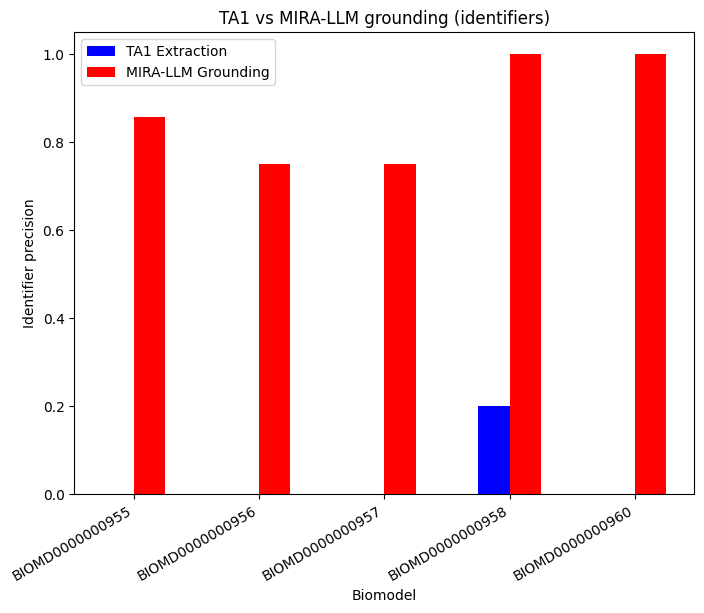

In [22]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = 0.25
x = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(
    x - bar_width / 2,
    ta1_identifier_precision,
    width=bar_width,
    label="TA1 Extraction",
    color="blue",
    align="center",
)


ax.bar(
    x + bar_width / 2,
    llm_identifier_precision,
    width=bar_width,
    label="MIRA-LLM Grounding",
    color="red",
    align="center",
)

ax.set_xlabel("Biomodel")
ax.set_ylabel("Identifier precision")
ax.set_title("TA1 vs MIRA-LLM grounding (identifiers)")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_xticklabels(categories, rotation=30, ha="right")
ax.legend()

plt.show()